In [10]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import vstack, csc_matrix, coo_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [11]:
ratings = pd.read_csv("../data_AI/ratings.csv")
movies = pd.read_csv("../data_AI/movies.csv")
tags = pd.read_csv("../data_AI/tags.csv")

top_10movies = ratings["movieId"].value_counts().head(10).index
top_10_movies_data = movies[movies["movieId"].isin(top_10movies)]

top_10_movies_data



,movieId,title,genres
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
292,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
314,318,"Shawshank Redemption, The (1994)",Crime|Drama
351,356,Forrest Gump (1994),Comedy|Drama|Romance|War
475,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
522,527,Schindler's List (1993),Drama|War
585,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
1166,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
2480,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2867,2959,Fight Club (1999),Action|Crime|Drama|Thriller


In [12]:
# avarage_ratings = ratings[ratings['movieId'].isin(top_10movies)].groupby('movieId')['rating'].mean()
# avarage_ratings

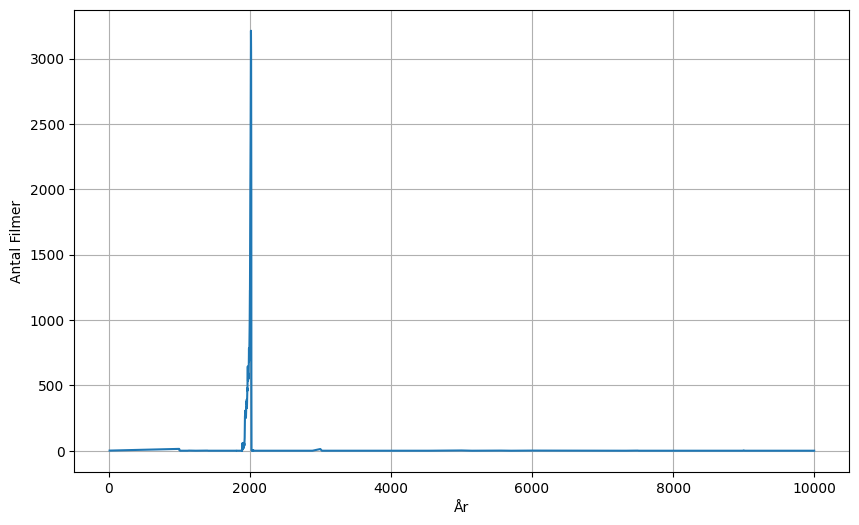

In [13]:
movies['year'] = movies['title'].str.extract(r'(\d{4})').astype(float)
movies_per_year = movies.groupby('year').size()
movies_per_year_filtered = movies_per_year.dropna()


plt.figure(figsize=(10, 6))
movies_per_year_filtered.plot(kind='line')
plt.title=('ÅR för bajre dag')
plt.xlabel('År')
plt.ylabel('Antal Filmer')
plt.grid(True)
plt.show()

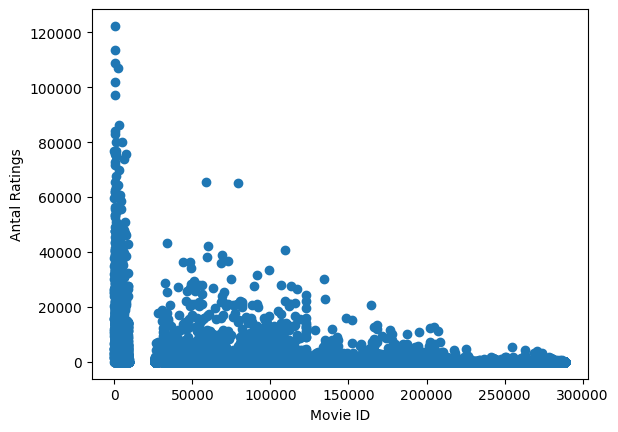

In [14]:
plt.scatter(ratings['movieId'].value_counts().index, ratings['movieId'].value_counts().values)
plt.xlabel('Movie ID')
plt.ylabel('Antal Ratings')
plt.show()


In [15]:
# avarage_ratings.plot(kind='bar')

In [16]:

average_ratings = ratings.groupby('movieId')['rating'].mean()
highly_rated_movies = average_ratings[average_ratings >= 1].index.tolist()

min_movie_ratings = 23
min_user_ratings = 23

filtered_movies = ratings['movieId'].value_counts() >= min_movie_ratings
filtered_movies = filtered_movies[filtered_movies].index.tolist()

filtered_users = ratings['userId'].value_counts() >= min_user_ratings
filtered_users = filtered_users[filtered_users].index.tolist()

df_filtered = ratings[(ratings['movieId'].isin(filtered_movies)) & 
                      (ratings['userId'].isin(filtered_users)) & 
                      (ratings['movieId'].isin(highly_rated_movies))]

df_filtered_copy = df_filtered.copy()
df_filtered_copy['movieId'] = df_filtered_copy['movieId'].astype('category')
df_filtered_copy['userId'] = df_filtered_copy['userId'].astype('category')

rows = df_filtered_copy['movieId'].cat.codes
cols = df_filtered_copy['userId'].cat.codes
data = df_filtered_copy['rating']

coo = coo_matrix((data, (rows, cols)), shape=(df_filtered_copy['movieId'].cat.categories.size, df_filtered_copy['userId'].cat.categories.size))
sparse_matrix = csc_matrix(coo)




In [17]:
movies_with_tags = pd.merge( movies, tags, on='movieId', how='left')

aggregated_tags = movies_with_tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x.dropna())).reset_index()

movies_with_full_profile = pd.merge(movies, aggregated_tags, on='movieId', how='left')

movies_with_full_profile['profile'] = movies_with_full_profile['genres'] + ' ' + movies_with_full_profile['tag']

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_with_full_profile['profile'])

In [18]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
model_knn.fit(sparse_matrix)

def get_movie_recommendations(movie_id, movies_df, model, sparse_matrix, k=10):
    if movie_id not in movies_df['movieId'].values:
        return "Movie ID not found"

    movie_title = movies_df[movies_df['movieId'] == movie_id]['title'].iloc[0]

    # Använd movieId för att hitta indexet i den sparade matrisen
    movie_idx = pd.Index(movies_df['movieId']).get_loc(movie_id)

    # Hämta rekommendationer med NearestNeighbors-modellen
    distances, indices = model.kneighbors(sparse_matrix[movie_idx], n_neighbors=k+1)
    similar_movies_indices = indices.flatten()[1:]

    # Hämta och returnera titlar för liknande filmer
    similar_movies_ids = movies_df.iloc[similar_movies_indices]['movieId']
    similar_movies_titles = movies_df[movies_df['movieId'].isin(similar_movies_ids)]['title']
    
    return movie_title, similar_movies_titles

# Använd funktionen för att hitta liknande filmer
movie_id = 2000  # Ett exempel på movieId
original_title, similar_movies = get_movie_recommendations(movie_id, movies, model_knn, sparse_matrix)
print(f"Filmer liknande '{original_title}' (movieId {movie_id}):\n{similar_movies}")


Filmer liknande 'Lethal Weapon (1987)' (movieId 2000):
969                                Michael Collins (1996)
977                                        Curdled (1996)
979                                 Ed's Next Move (1996)
990                               Parent Trap, The (1961)
991                                      Pollyanna (1960)
1883    Nightmare on Elm Street 5: The Dream Child, A ...
1885                               Friday the 13th (1980)
1915                     Gremlins 2: The New Batch (1990)
1955                     Devil and Max Devlin, The (1981)
1966                        Hot Lead and Cold Feet (1978)
Name: title, dtype: object


In [19]:
def get_content_based_recommendations(movie_id, movies_df, tfidf_matrix, k=10):
    # Kontrollera först om filmen finns i datasetet
    if movie_id not in movies_df['movieId'].values:
        return f"No recommendations found for movie ID {movie_id}"

    # Hitta filmens titel
    movie_title = movies_df[movies_df['movieId'] == movie_id]['title'].iloc[0]

    # Hitta index för det angivna movieId i tfidf_matrix
    movie_index = movies_df.index[movies_df['movieId'] == movie_id].tolist()[0]
    movie_tfidf = tfidf_matrix[movie_index]

    # Beräkna cosine-similaritet
    cosine_similarity = linear_kernel(movie_tfidf, tfidf_matrix).flatten()

    # Hitta index för liknande filmer
    similar_indices = cosine_similarity.argsort()[:-k-1:-1]
    similar_movies = movies_df.iloc[similar_indices]['title']

    return movie_title, similar_movies

# Hitta rekommenderade filmer för ett specifikt movieId
movie_id = 2000
original_title, recommended_movies = get_content_based_recommendations(movie_id, movies, tfidf_matrix)
print(f"Rekommendationer baserade på filmen '{original_title}':\n{recommended_movies}")


Rekommendationer baserade på filmen 'Lethal Weapon (1987)':
1911       Lethal Weapon (1987)
1912     Lethal Weapon 2 (1989)
1913     Lethal Weapon 3 (1992)
1829     Lethal Weapon 4 (1998)
3176       Forever Young (1992)
3605      Bird on a Wire (1990)
363             Maverick (1994)
3653        Patriot, The (2000)
3915     What Women Want (2000)
32967            Veteran (2015)
Name: title, dtype: object


In [20]:
def hybrid_recommendations(movie_id, movies_df, model, sparse_matrix, tfidf_matrix, k=10, knn_weight=0.3, content_weight=0.7):
    # Hitta filmens titel
    if movie_id not in movies_df['movieId'].values:
        return f"No recommendations found for movie ID {movie_id}"
    original_title = movies_df[movies_df['movieId'] == movie_id]['title'].iloc[0]

    # Hämta innehållsbaserade rekommendationer
    _, content_based_recommendations = get_content_based_recommendations(movie_id, movies_df, tfidf_matrix, k)
    
    # Hämta kollaborativa rekommendationer
    knn_recommendations = get_movie_recommendations(movie_id, movies_df, model, sparse_matrix, k)[1] 

    # Kombinera rekommendationerna
    combined_recommendations = (content_based_recommendations.tolist() * int(content_weight * k) + knn_recommendations.tolist() * int(knn_weight * k))[:k]

    # Räkna och ranka rekommendationer
    movie_scores = {movie: combined_recommendations.count(movie) for movie in set(combined_recommendations)}
    top_movies = sorted(movie_scores, key=movie_scores.get, reverse=True)[:k]

    # Skapa resultatlista
    top_movies_series = pd.Series(top_movies, name="Recommended Movies")
    return original_title, top_movies_series


# Använda funktionen
movie_id = 2000  
original_title, hybrid_recs = hybrid_recommendations(movie_id, movies, model_knn, sparse_matrix, tfidf_matrix)
print(f"Hybrid rekommendationer baserade på filmen '{original_title}':\n{hybrid_recs}")





    


Hybrid rekommendationer baserade på filmen 'Lethal Weapon (1987)':
0    Lethal Weapon 2 (1989)
1      Lethal Weapon (1987)
2     Bird on a Wire (1990)
3    What Women Want (2000)
4    Lethal Weapon 4 (1998)
5      Forever Young (1992)
6           Maverick (1994)
7    Lethal Weapon 3 (1992)
8       Patriot, The (2000)
9            Veteran (2015)
Name: Recommended Movies, dtype: object
